In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

## Transactions csv

In [5]:
Transations = pd.read_csv('DataSets/2013/transactions.csv',
                          names=['timestamp', 'blockId',
                                 'txId', 'isCoinbase', 'fee'],
                          dtype={'timestamp': 'int64', 'blockId': 'uint32',
                                 'txId': 'uint32', 'isCoinbase': 'bool', 'fee': 'uint64'})
Transations.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532115 entries, 0 to 10532114
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   timestamp   int64 
 1   blockId     uint32
 2   txId        uint32
 3   isCoinbase  bool  
 4   fee         uint64
dtypes: bool(1), int64(1), uint32(2), uint64(1)
memory usage: 251.1 MB


In [6]:
Transations['timestamp'] = pd.to_datetime(Transations['timestamp'],unit='s')

In [93]:
Transations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532115 entries, 0 to 10532114
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   blockId     uint32        
 2   txId        uint32        
 3   isCoinbase  bool          
 4   fee         uint64        
dtypes: bool(1), datetime64[ns](1), uint32(2), uint64(1)
memory usage: 251.1 MB


## Inputs csv

In [ ]:
Inputs = pd.read_csv('DataSets/2013/inputs.csv',
                     names=['txId', 'prevTxId', 'prevTxpos'],
                     dtype={'prevTxpos': 'uint16', 'prevTxId': 'uint32',
                                 'txId': 'uint32'}
                     )
Inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21378770 entries, 0 to 21378769
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   txId       uint32
 1   prevTxId   uint32
 2   prevTxpos  uint16
dtypes: uint16(1), uint32(2)
memory usage: 203.9 MB


In [95]:
Inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21378770 entries, 0 to 21378769
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   txId       uint32
 1   prevTxId   uint32
 2   prevTxpos  uint16
dtypes: uint16(1), uint32(2)
memory usage: 203.9 MB


## Outputs csv

In [4]:
Outputs = pd.read_csv('DataSets/2013/outputs.csv',
                      names=['txId', 'position', 'addressId',
                             'amount', 'scripttype'],
                      dtype={'txId': 'uint32',
                             'position': 'uint16',
                             'addressId': 'uint32',
                             'amount': 'uint64',
                             'scripttype ': 'int'})
Outputs.info()


FileNotFoundError: [Errno 2] No such file or directory: 'DataSets/2013/outputs.csv'

In [97]:
Outputs['scripttype'] = Outputs['scripttype'].astype('category')

In [98]:
Outputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24573071 entries, 0 to 24573070
Data columns (total 5 columns):
 #   Column      Dtype   
---  ------      -----   
 0   txId        uint32  
 1   position    uint16  
 2   addressId   uint32  
 3   amount      uint64  
 4   scripttype  category
dtypes: category(1), uint16(1), uint32(2), uint64(1)
memory usage: 445.3 MB


## Mapping csv

In [99]:
Mapping = pd.read_csv('DataSets/2013/mapAddr2Ids8708820.csv',
                      names=['hash', 'addressId'])
Mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708821 entries, 0 to 8708820
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   hash       object
 1   addressId  int64 
dtypes: int64(1), object(1)
memory usage: 132.9+ MB


In [100]:
Mapping['addressId'] = pd.to_numeric(Mapping['addressId'],downcast='unsigned')

In [101]:
Mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708821 entries, 0 to 8708820
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   hash       object
 1   addressId  uint32
dtypes: object(1), uint32(1)
memory usage: 99.7+ MB


## Controlli di validità delle transazioni

- Input/output che fanno riferimento ad un tx_id non contenuto in
nessun blocco
- Input che fanno riferimento ad un output_id non esistente


In [102]:
x = pd.merge(left=Inputs.set_index(['txId']), right=Transations.set_index(['txId']), how='left', indicator=True,left_index=True,right_index=True)
x['_merge'].value_counts()


_merge
both          21378770
left_only            0
right_only           0
Name: count, dtype: int64

In [103]:
x = pd.merge(left=Outputs.set_index(['txId']), right=Transations.set_index(['txId']), how='left', indicator=True,left_index=True,right_index=True)
x['_merge'].value_counts()

_merge
both          24573071
left_only            0
right_only           0
Name: count, dtype: int64

In [104]:
temp = (~Inputs['prevTxId'].isin(Outputs['txId']))
temp.describe()

count     21378770
unique           1
top          False
freq      21378770
Name: prevTxId, dtype: object

In [105]:
del temp
del x

## Analisi Generali

### Distribuzione numero transazioni per blocco

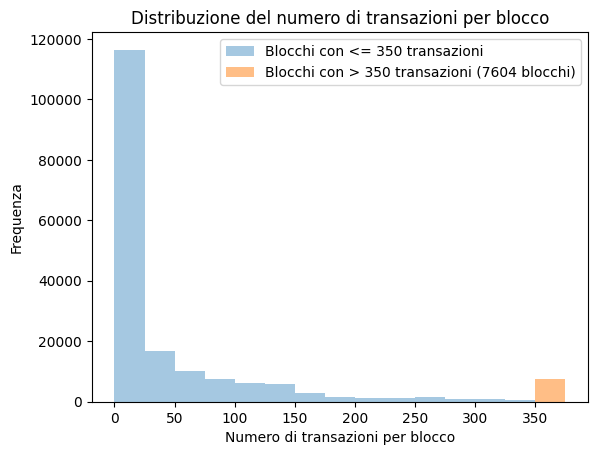

In [106]:
# raggruppa le transazioni per blockId e calcola il numero di transazioni per ogni blocco
tx_per_block = Transations.groupby('blockId')['txId'].count().reset_index()
tx_per_block.rename(columns={'txId': 'num_tx'}, inplace=True)

# impostiamo la soglia e il valore da assegnare ai blocchi sopra la soglia
threshold = 350
clip_value = threshold + 1

# impostiamo i valori sopra la soglia al valore di clip
tx_per_block['num_tx'] = np.clip(tx_per_block['num_tx'], a_min=None, a_max=threshold, out=None)
tx_per_block['num_tx'] = tx_per_block['num_tx'].replace(to_replace=threshold, value=clip_value)

# calcoliamo l'istogramma dei valori clip
bin_width = 25
bins = np.arange(0, clip_value + bin_width, bin_width)
plt.hist(tx_per_block[tx_per_block['num_tx'] <= threshold]['num_tx'], bins=bins.tolist(), alpha=0.4, label='Blocchi con <= {} transazioni'.format(threshold))

# plottiamo un unico bin per i blocchi sopra la soglia
num_over_threshold = len(tx_per_block[tx_per_block['num_tx'] > threshold])
plt.hist(tx_per_block[tx_per_block['num_tx'] > threshold]['num_tx'], bins=bins.tolist(), alpha=0.5, label='Blocchi con > {} transazioni ({} blocchi)'.format(threshold, num_over_threshold))

plt.xlabel("Numero di transazioni per blocco")
plt.ylabel("Frequenza")
plt.title("Distribuzione del numero di transazioni per blocco")
plt.legend()
plt.show()

### Numero Transazioni medie su 2 mesi

<Axes: xlabel='timestamp'>

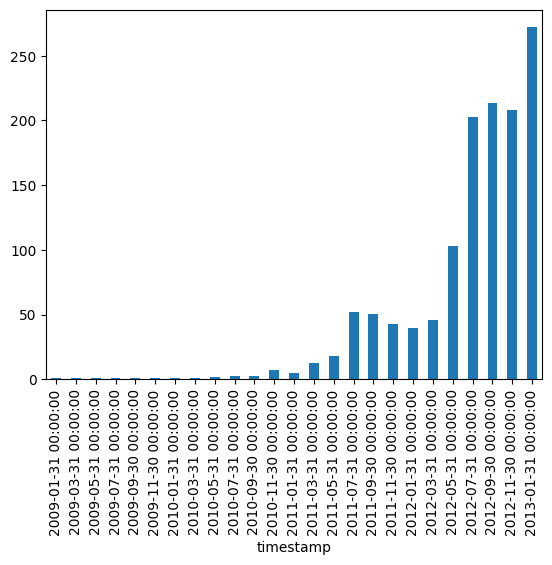

In [107]:
x = Transations.groupby(
    ['blockId','timestamp'], as_index=False)['txId'].nunique()

x = x.set_index('timestamp')
x.resample(rule='2M')['txId'].mean().plot(kind='bar')


In [108]:
x = Transations.groupby('timestamp')['blockId'].nunique()
x.describe()

count    181012.000000
mean          1.000425
std           0.020621
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: blockId, dtype: float64

In [109]:
x = Transations.groupby('blockId')['timestamp'].nunique()
x.describe()

count    181089.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: timestamp, dtype: float64

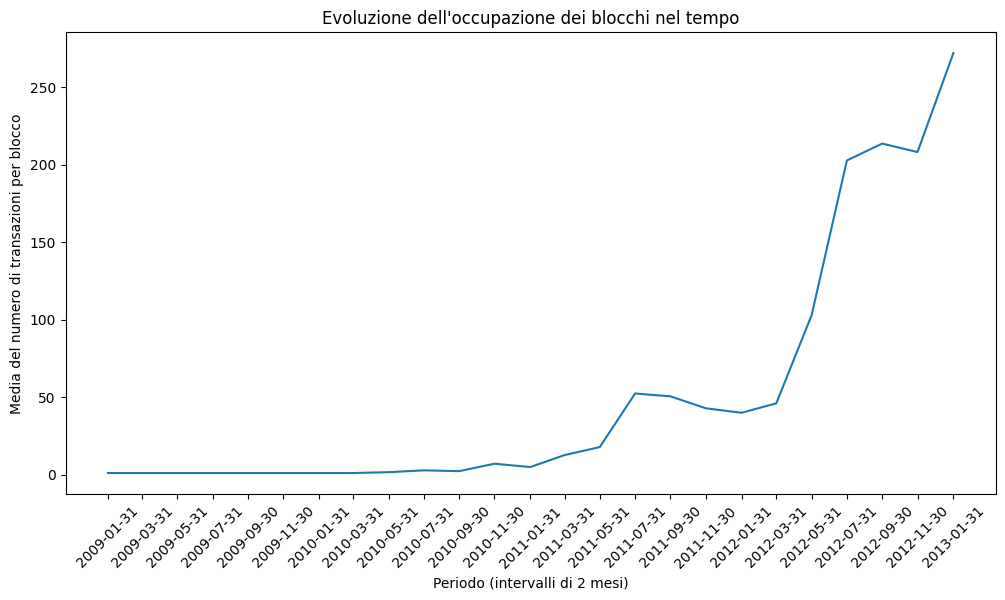

In [110]:



df = Transations.set_index('timestamp')

# crea un nuovo dataframe che contiene il numero di transazioni per blockId e periodo di due mesi
tx_per_block = df.groupby([pd.Grouper(freq='2M'), 'blockId'])['txId'].count().reset_index()
tx_per_block.rename(columns={'txId': 'num_tx'}, inplace=True)

# calcola la media del numero di transazioni per ogni blocco e periodo di due mesi
mean_tx_per_block = tx_per_block.groupby(pd.Grouper(key='timestamp', freq='2M'))['num_tx'].mean().reset_index()

# plotta il numero di transazioni medie per periodo di due mesi
plt.figure(figsize=(12, 6))
plt.plot(mean_tx_per_block['timestamp'], mean_tx_per_block['num_tx'])
plt.xlabel("Periodo (intervalli di 2 mesi)")
plt.ylabel("Media del numero di transazioni per blocco")
plt.title("Evoluzione dell'occupazione dei blocchi nel tempo")
plt.xticks(mean_tx_per_block['timestamp'],rotation=45)
plt.show()


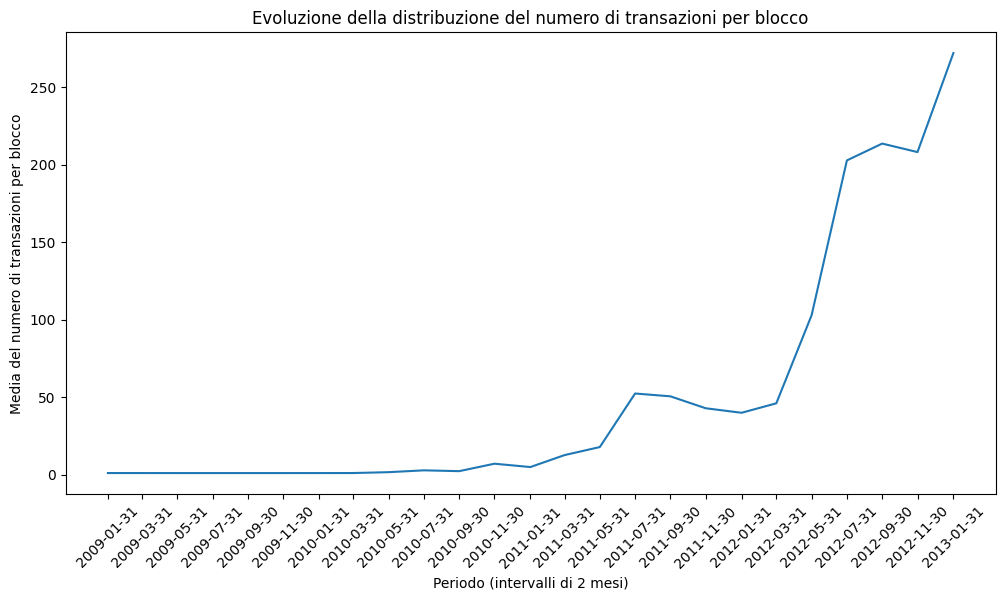

In [111]:
transactions = Transations.sort_values(by='timestamp')
transactions.set_index('timestamp', inplace=True)

average_transactions = transactions.groupby([pd.Grouper(freq='2M'),'blockId'])['txId'].count().reset_index()
average_transactions = average_transactions.groupby('timestamp')['txId'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(average_transactions['timestamp'], average_transactions['txId'])
plt.xlabel("Periodo (intervalli di 2 mesi)")
plt.ylabel("Media del numero di transazioni per blocco")
plt.title("Evoluzione della distribuzione del numero di transazioni per blocco")
plt.xticks(average_transactions['timestamp'],rotation=45)
plt.show()

### UTXO totale

In [112]:
temp = (~Outputs['txId'].isin(Inputs['prevTxId']))
temp.describe()

count     24573071
unique           2
top          False
freq      24489865
Name: txId, dtype: object

In [113]:
UTXO = Outputs.loc[temp]

<Axes: >

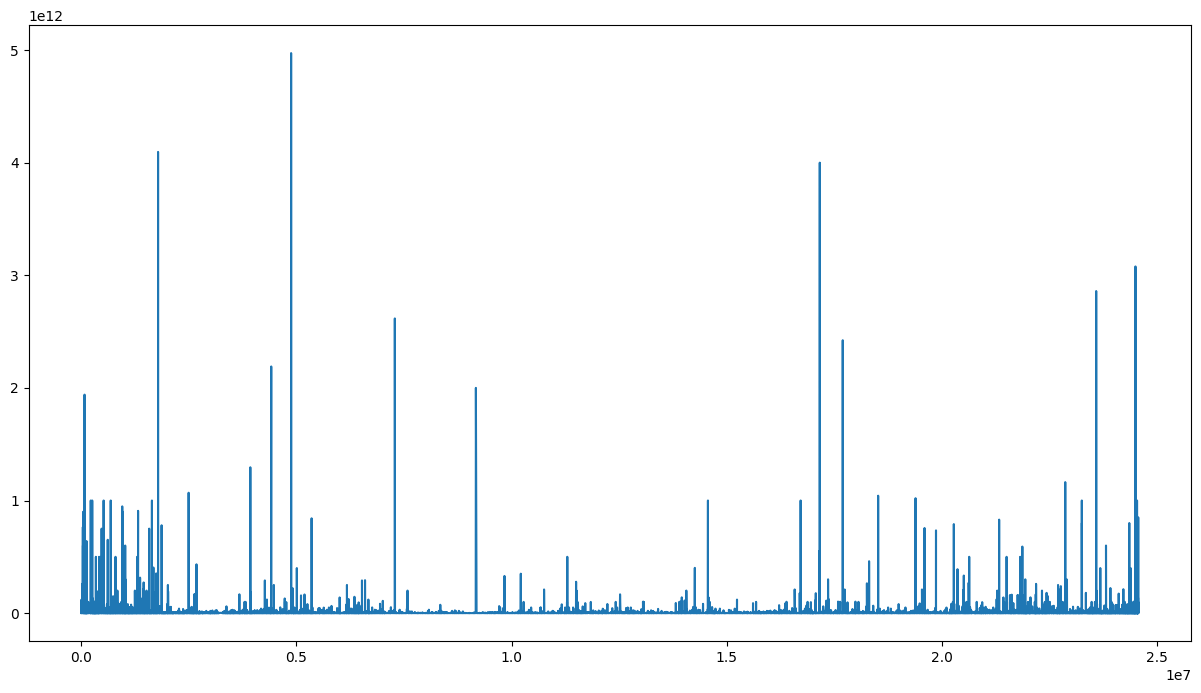

In [114]:
plt.figure(figsize=(15, 8))
UTXO['amount'].plot()

In [115]:
unspent_outputs = Outputs[~Outputs['txId'].isin(Inputs['prevTxId'])]
utxo_amount = unspent_outputs['amount'].sum()
print("Ammontare totale degli UTXO al momento dell'ultima transazione: {:,}".format(utxo_amount).replace(",", "."))

Ammontare totale degli UTXO al momento dell'ultima transazione: 218.593.937.985.378


11            100000000
41           6100000000
63          25000000000
64           5000000000
82          10000000000
               ...     
24573066              1
24573067        9899999
24573068       26651306
24573069     7991620447
24573070     7991620447
Name: amount, Length: 83206, dtype: uint64

#### distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output (UTXO) e quella che lo consuma, per gli output spesi nel periodo considerato.

In [116]:
Outputs['txId'] = Outputs['txId'].astype('int32')
Transations['txId'] = Transations['txId'].astype('int32')
Outputs['position'] = Outputs['position'].astype('int32')
Inputs['prevTxId'] = Inputs['prevTxId'].astype('int32')
Inputs['prevTxpos'] = Inputs['prevTxpos'].astype('int32')
# Seleziona solo gli output che vengono consumati come input da un'altra transazione
output_consumati = Outputs[Outputs['txId'].isin(Inputs['prevTxId'])]




In [117]:
inputs_with_timestamps = pd.merge(Inputs[['txId','prevTxId']], Transations[['txId','timestamp']], left_on="txId", right_on="txId", how="left")
inputs_with_timestamps.rename(columns={"timestamp": "consumption_timestamp"}, inplace=True)



In [118]:
outputs_with_timestamps = pd.merge(output_consumati['txId'], Transations[['txId','timestamp']], left_on="txId", right_on="txId", how="left")


In [119]:
outputs_with_timestamps.rename(columns={"timestamp": "creation_timestamp"}, inplace=True)


In [120]:
merged_data = pd.merge(inputs_with_timestamps, outputs_with_timestamps, left_on="prevTxId", right_on="txId", how="inner", suffixes=("_input", "_output"))
merged_data["time_interval"] = merged_data["consumption_timestamp"] - merged_data["creation_timestamp"]


In [121]:
merged_data["time_interval"]

0             2 days 23:35:46
1             0 days 02:31:48
2             0 days 02:31:48
3           673 days 17:09:02
4           673 days 17:09:02
                   ...       
288485120     0 days 00:00:00
288485121     0 days 00:00:00
288485122     0 days 00:00:00
288485123     0 days 00:00:00
288485124     0 days 00:00:00
Name: time_interval, Length: 288485125, dtype: timedelta64[ns]

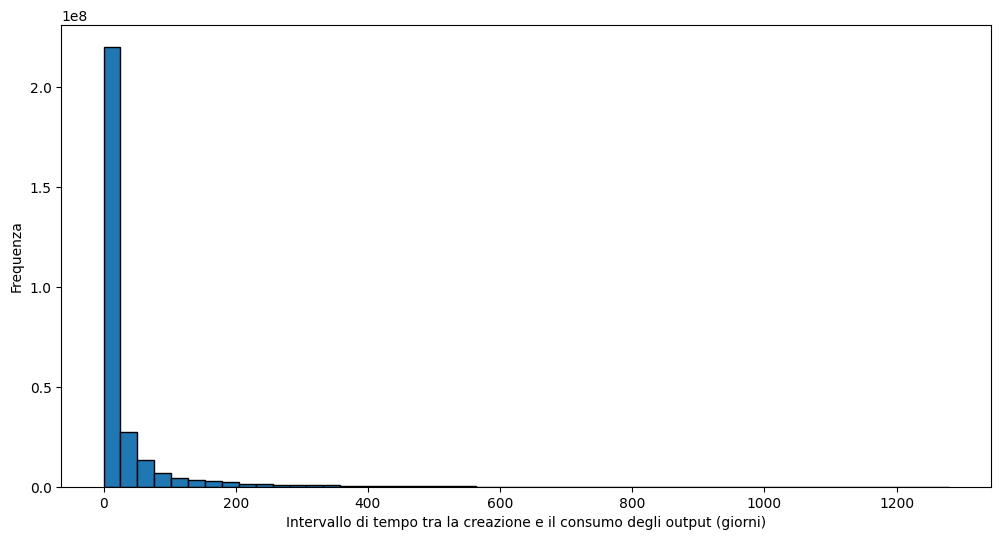

In [122]:
# Calcola l'intervallo di tempo in ore direttamente durante la creazione dell'istogramma
time_interval_hours = (merged_data["time_interval"].dt.total_seconds() / (3600*24)).astype('float64')

# Disegna l'istogramma
plt.figure(figsize=(12, 6))
plt.hist(time_interval_hours, bins=50, edgecolor='black')
plt.xlabel("Intervallo di tempo tra la creazione e il consumo degli output (giorni)")
plt.ylabel("Frequenza")
plt.show()


Un'ulteriore analisi che potrebbe essere interessante è esaminare la correlazione tra le commissioni delle transazioni e il tempo necessario per confermare una transazione. Questo potrebbe aiutare a capire quanto le commissioni influenzano il tempo di conferma delle transazioni nel periodo considerato.

Calcola il tempo di conferma per ogni transazione.
Esamina la correlazione tra le commissioni e il tempo di conferma delle transazioni.
Visualizza i risultati in un grafico a dispersione.

In [123]:
# Unisci i DataFrame degli input e delle transazioni
transaction_inputs = pd.merge(Transations[['txId', 'timestamp', 'fee']], Inputs[[
                              'txId', 'prevTxId']], on='txId')

# Rinomina le colonne per evitare conflitti durante il merge_asof
transaction_outputs = pd.merge(Transations[[
                               'txId', 'timestamp']], Outputs['txId'], left_on='txId', right_on='txId', suffixes=('', '_prev'))

transaction_outputs.rename(
    columns={'txId': 'prevTxId', 'timestamp': 'timestamp_prev'}, inplace=True)





In [124]:
transaction_inputs_sample = transaction_inputs#.sample(frac=0.2) nel caso sia troppo lento effettuiamo un sampling
transaction_outputs_sample = transaction_outputs[transaction_outputs['prevTxId'].isin(transaction_inputs_sample['txId'])].copy()
# Ordina i DataFrame in base ai prevTxId e ai timestamp
transaction_inputs_sample.sort_values(['timestamp'], inplace=True)
transaction_outputs_sample.sort_values(['timestamp_prev'], inplace=True)

In [125]:
# Esegui il merge_asof tra i DataFrame degli output e degli input
transaction_outputs_sample = pd.merge_asof(transaction_inputs_sample, transaction_outputs_sample[[
                                    'prevTxId', 'timestamp_prev']], left_on='timestamp', right_on='timestamp_prev', by='prevTxId', direction='backward')

La correlazione tra commissioni e tempo di conferma è: 0.02894423714070229


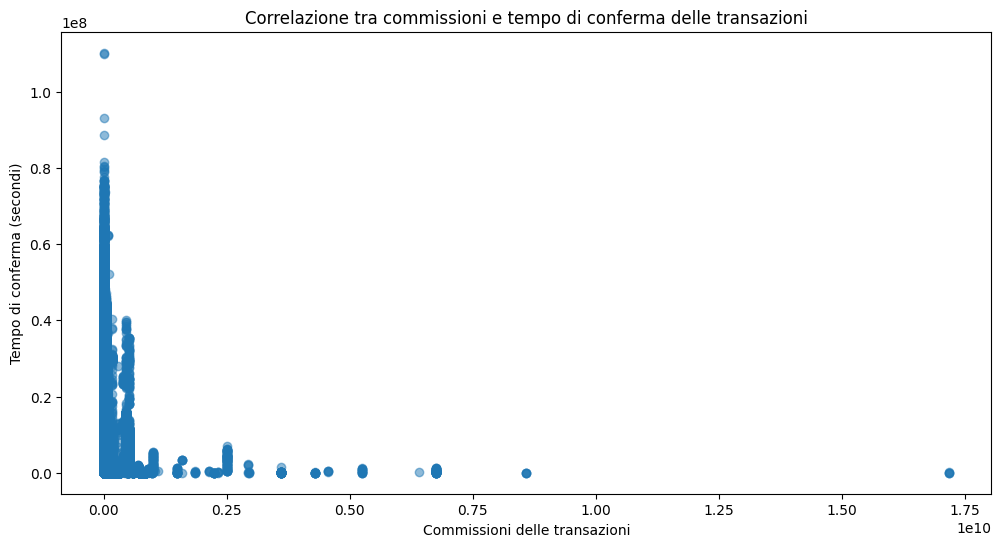

In [126]:

# Calcola il tempo di conferma per ogni transazione
transaction_outputs_sample['confirmation_time'] = (
    transaction_outputs_sample['timestamp'] - transaction_outputs_sample['timestamp_prev']).dt.total_seconds()

# Calcola il primo e il terzo quartile e l'intervallo interquartile (IQR)
Q1 = transaction_outputs_sample['fee'].quantile(0.25)
Q3 = transaction_outputs_sample['fee'].quantile(0.75)
IQR = Q3 - Q1

# Crea una maschera booleana per filtrare gli outlier
mask = ((transaction_outputs_sample['fee'] >= (Q1 - 1.5 * IQR)) &
        (transaction_outputs_sample['fee'] <= (Q3 + 1.5 * IQR)))

# Filtra il DataFrame utilizzando la maschera
transaction_outputs_sample_filtered = transaction_outputs_sample#[mask]
# Calcola la correlazione tra le commissioni e il tempo di conferma
correlation = transaction_outputs_sample_filtered['fee'].corr(
    transaction_outputs_sample_filtered['confirmation_time'])

print("La correlazione tra commissioni e tempo di conferma è:", correlation)

# Visualizza i risultati in un grafico a dispersione
plt.figure(figsize=(12, 6))
plt.scatter(transaction_outputs_sample_filtered['fee'],
            transaction_outputs_sample_filtered['confirmation_time'], alpha=0.5)
plt.xlabel("Commissioni delle transazioni")
plt.ylabel("Tempo di conferma (secondi)")
plt.title("Correlazione tra commissioni e tempo di conferma delle transazioni")
plt.show()

In [ ]:
# Filtra il DataFrame utilizzando la maschera
transaction_outputs_sample_filtered = transaction_outputs_sample[mask]
# Calcola la correlazione tra le commissioni e il tempo di conferma
correlation = transaction_outputs_sample_filtered['fee'].corr(
    transaction_outputs_sample_filtered['confirmation_time'])

print("La correlazione tra commissioni e tempo di conferma è:", correlation)

# Visualizza i risultati in un grafico a dispersione
plt.figure(figsize=(12, 6))
plt.scatter(transaction_outputs_sample_filtered['fee'],
            transaction_outputs_sample_filtered['confirmation_time'], alpha=0.5)
plt.xlabel("Commissioni delle transazioni")
plt.ylabel("Tempo di conferma (secondi)")
plt.title("Correlazione tra commissioni e tempo di conferma delle transazioni (filtrata)")
plt.show()

## Clustering

Questa parte è stata sviluppata nei file preprocessing.py, che genera un file json, e scaper.py che partendo dal json effettua lo scraping su i due siti proposti.I notebook non gestiscono bene la memoria RAM, con i vari merge l'utilizzo totale raggiuge facilmente i 16GB e non viene liberata a fine processamento. Lascio anche qui il codice per comodità

In [127]:
from collections import defaultdict

In [128]:
# Select only the necessary columns
reduced_outputs = Outputs[['addressId', 'txId', 'position']]
reduced_inputs = Inputs[['txId', 'prevTxId', 'prevTxpos']]

# Merge Inputs and Outputs using prevTxId
merged_data = pd.merge(reduced_inputs, reduced_outputs, left_on=['prevTxId', 'prevTxpos'], right_on=['txId', 'position'], how='inner')

# Filtra solo le transazioni con più di un input
multiple_input_txs = merged_data[merged_data.duplicated(subset=['txId_x'], keep=False)]


In [129]:
class UnionFind:
    def __init__(self):
        self.parent = dict()
        self.rank = dict()

    def make_set(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x == root_y:
            return

        if self.rank[root_x] > self.rank[root_y]:
            self.parent[root_y] = root_x
        else:
            self.parent[root_x] = root_y
            if self.rank[root_x] == self.rank[root_y]:
                self.rank[root_y] += 1
                
def cluster_addresses_union_find_opt_v4(multiple_input_txs):
    uf = UnionFind()

    # Crea un set di tutti gli indirizzi presenti nei dati
    all_addresses = set(multiple_input_txs['addressId'].unique())

    # Inizializza l'oggetto uf con tutti gli indirizzi unici
    for address in all_addresses:
        uf.make_set(address)

    for _, group in multiple_input_txs.groupby('txId_x'):
        addresses = group['addressId'].tolist()

        # Unisci tutti gli indirizzi nell'input corrente nel nuovo cluster
        for i in range(1, len(addresses)):
            uf.union(addresses[i - 1], addresses[i])

    cluster_mapping = {}
    for address in all_addresses:
        root = uf.find(address)
        if root not in cluster_mapping:
            cluster_mapping[root] = []
        cluster_mapping[root].append(address)
        
    return cluster_mapping


In [130]:
output_clustering = cluster_addresses_union_find_opt_v4(multiple_input_txs)
output_clustering

KeyboardInterrupt: 

In [133]:
import json

with open("clusters.json","r") as f:
    data = json.load(f)

In [134]:
import numpy as np

# Calcola le dimensioni di ciascun cluster
cluster_sizes = [len(addresses) for addresses in data.values()]

# Calcola la dimensione media, minima e massima dei cluster
mean_size = np.mean(cluster_sizes)
min_size = np.min(cluster_sizes)
max_size = np.max(cluster_sizes)

print("Dimensione media dei cluster:", mean_size)
print("Dimensione minima dei cluster:", min_size)
print("Dimensione massima dei cluster:", max_size)

Dimensione media dei cluster: 8.404291154348938
Dimensione minima dei cluster: 1
Dimensione massima dei cluster: 259773


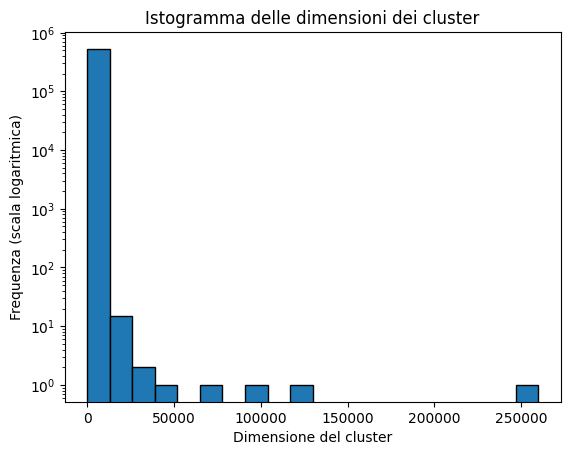

In [135]:

plt.hist(cluster_sizes, bins=20, edgecolor='black', log=True)
plt.xlabel('Dimensione del cluster')
plt.ylabel('Frequenza (scala logaritmica)')
plt.title('Istogramma delle dimensioni dei cluster')
plt.show()

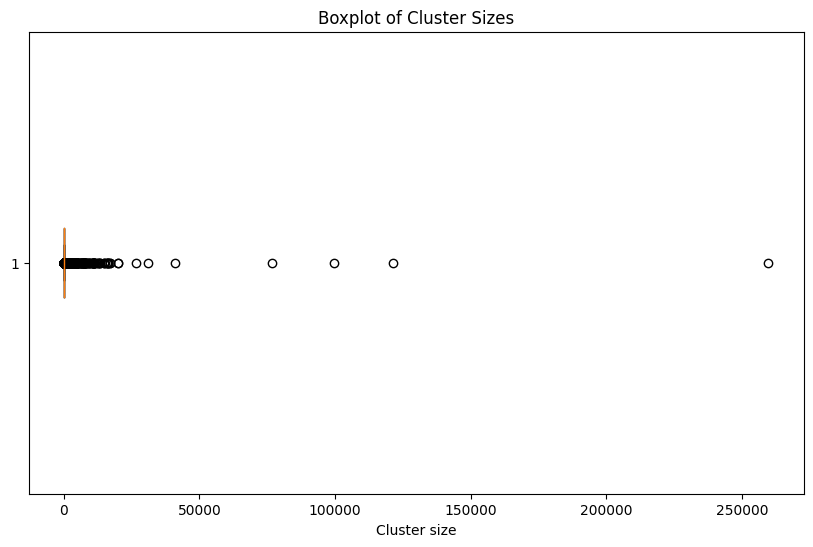

In [136]:
cluster_sizes_series = pd.Series(cluster_sizes)

plt.figure(figsize=(10, 6))
plt.boxplot(cluster_sizes_series, vert=False)
plt.title('Boxplot of Cluster Sizes')
plt.xlabel('Cluster size')
plt.show()

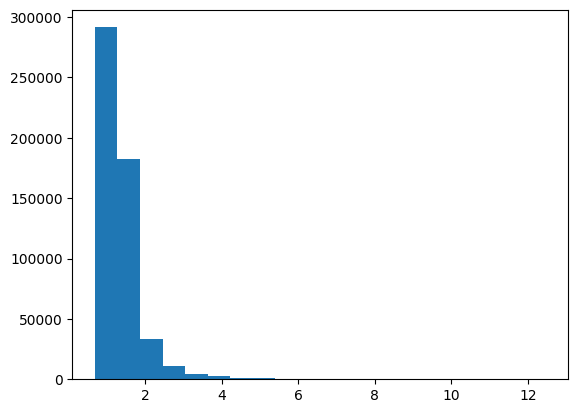

In [137]:
log_cluster_sizes = np.log1p(cluster_sizes_series)  # log1p(x) calcola log(1 + x)
plt.hist(log_cluster_sizes, bins=20)
plt.show()

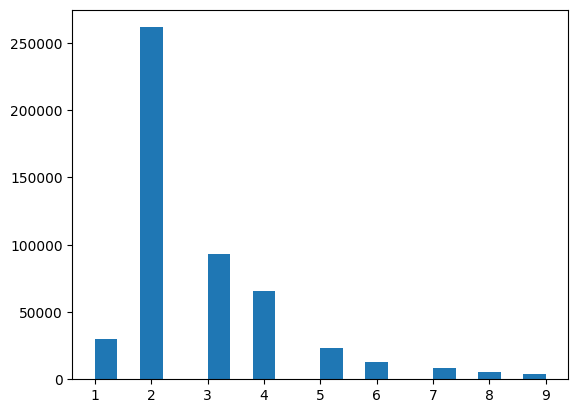

In [138]:
truncated_cluster_sizes = cluster_sizes_series[cluster_sizes_series < 10]   # type: ignore
plt.hist(truncated_cluster_sizes, bins=20)
plt.show()

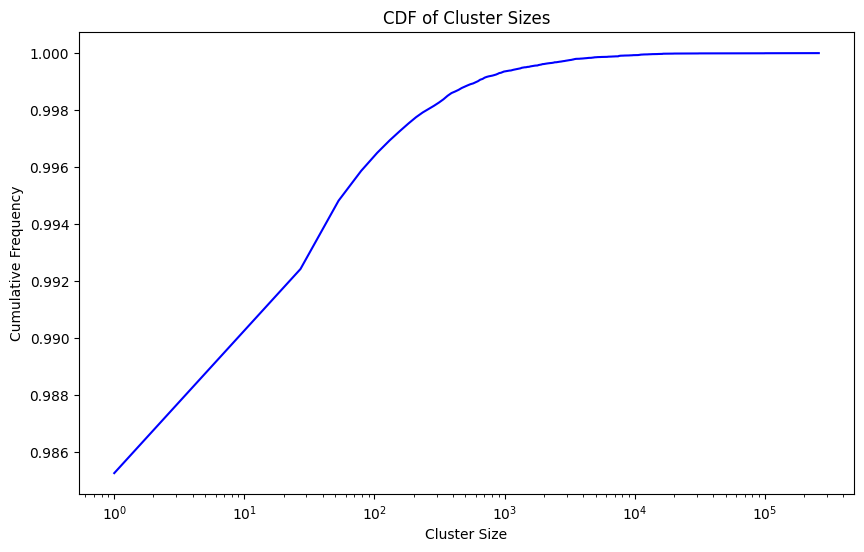

In [140]:
# Genera i dati per la CDF
values, base = np.histogram(cluster_sizes, bins=10000, density=True)
bin_widths = base[1:] - base[:-1]
values *= bin_widths
cumulative = np.cumsum(values)
#cumulative /= cumulative[-1]  
# Crea un nuovo grafico
plt.figure(figsize=(10, 6))

# Traccia i dati
plt.plot(base[:-1], cumulative, c='blue')
plt.xscale('log')
# Imposta i titoli del grafico e degli assi
plt.title('CDF of Cluster Sizes')
plt.xlabel('Cluster Size')
plt.ylabel('Cumulative Frequency')

# Mostra il grafico
plt.show()

In [ ]:
sorted_cluster = sorted(data.items(), key =lambda x: len(x[1]),reverse=True)

top_10 = sorted_cluster[0:10]

del sorted_cluster


In [ ]:
cluster0 = pd.DataFrame(top_10[0][1] + [top_10[0][0]],columns=['addressId'])
cluster0[cluster0['addressId'] == top_10[0][0]]

,addressId
121464,4409488


In [ ]:
cluster10 = pd.DataFrame(top_10[9][1] + [top_10[9][0]],columns=['addressId'])
cluster10[cluster10['addressId'] == top_10[9][0]]

,addressId
16918,2257367


In [ ]:
x =Mapping.merge(cluster10,how='inner')

In [ ]:
x

,hash,addressId
0,1ENngQ41W1kHn7hqYjzkG8DE5TYfhv6JZS,1874970
1,1AbgPFmFFkQHbYKgbKMMidUbhwRFiUaD8B,1875444
2,1PVPVVte8pghxRCpWLDCtALfXLQGw9DXVp,1876909
3,1DGhAM9yr2VszrwALXD7H6ZdqSyB8DRxSn,1889715
4,1GBNgYXZDkakkqcfnxApdBDxCiXP5igoMY,1918093
...,...,...
16913,19J732qTGXLj5V44Kv5zXzdXvDBsCZMj7D,8702001
16914,19Ar4YbN6oQBDM8xqhAMEpTztShCkja8Gx,8702833
16915,18zSAS8SoiJfCSm9xy8SbnvverZB5UWVU9,8702850
16916,19Ujrm1GojaiUgRr3FaYxvZeskNnqrEEWc,8704640


Per sviluppare il bot ho preferito utilizzare la libreria python-statemachine per facilitarmi la scrittura della logica tramite l'utilizzo di una macchina a stati finiti

In [ ]:
from selenium.webdriver.remote.webelement import WebElement
from statemachine import StateMachine, State
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

class CrawlerBot(StateMachine):
    # Definisci gli stati
    start = State('Start', initial=True)
    address_page_loaded = State('Address page loaded')
    wallet_page_loaded = State('Wallet page loaded')
    banned = State('Banned',final=True)
    OK = State("OK",final=True)

    # Definisci le transizioni
    loading_for_address = start.to(address_page_loaded,cond='thereAreAddress') | address_page_loaded.to(address_page_loaded,cond='thereAreAddress') | wallet_page_loaded.to(address_page_loaded,cond='thereAreAddress')
    loading_for_wallet = address_page_loaded.to(wallet_page_loaded,unless='thereIsCaptcha') | address_page_loaded.to(address_page_loaded,cond='thereAreAddress') | address_page_loaded.to(OK,unless='thereAreAddress')
    to_banned = address_page_loaded.to(banned,cond='thereIsCaptcha')

    finish = address_page_loaded.to(OK)

    def __init__(self, addresses,oneshot):
        self.driver = webdriver.Edge()  # o qualsiasi altro browser preferisci        
        self.driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
            "source": """
            Object.defineProperty(navigator, 'webdriver', {
            get: () => undefined
            })
        """
        })   
        self.oneshot = oneshot
        self.driver.implicitly_wait(3)
        self.addresses = set(addresses)  # Utilizzo un set per facilitare la rimozione degli indirizzi
        self.current_address = None
        self.wallet_names = {}
        super(CrawlerBot, self).__init__()

    def thereAreAddress(self):
        return len(self.addresses) > 0
        
    def thereIsCaptcha(self):
        try:
            captcha = self.driver.find_element(By.XPATH,"//*[contains(@class, 'captcha')]")
            print("Elemento con classe 'captcha' trovato.")
            return True
        except NoSuchElementException:
            print("Elemento con classe 'captcha' non trovato.")
            return False

    def get_address_url(self):
        return f"https://bitinfocharts.com/bitcoin/address/{self.current_address}" 

    def on_enter_address_page_loaded(self):
        self.current_address = self.addresses.pop()
        self.driver.get(self.get_address_url()) 
        self._scrape_wallet_name()        

    def on_enter_wallet_page_loaded(self):
        self._check_wallet_addresses()
        self.loading_for_address()

    def on_enter_OK(self):
        self.driver.quit()

    def _scrape_wallet_name(self):
        try:
            wallet_link = self.driver.find_element(By.XPATH,'//a[contains(@href, "/wallet/")]')
            self.wallet_names[self.current_address] = wallet_link.get_attribute("href").split('/wallet/')[-1]
            if (self.oneshot):
                self.finish()
                return
            wallet_link.click()
            print("Elemento link wallet trovato.")
            self.loading_for_wallet()
            return
        except NoSuchElementException:
            print("Elemento link wallet non trovato.")

        try:
            captcha = self.driver.find_element(By.XPATH,"//*[contains(@class, 'captcha')]")
            print("Elemento con classe 'captcha' trovato.")
            self.to_banned()
            return
        except NoSuchElementException:
            print("Elemento con classe 'captcha' non trovato.")
        self.loading_for_address()
        

    def _check_wallet_addresses(self):
        try:
            address_elements = self.driver.find_elements(By.CSS_SELECTOR,
                "#ShowAddresesContainer a"
            )
            wallet_addresses = {el.text for el in address_elements}
            self.addresses -= wallet_addresses  # Remove the addresses present in the wallet
            return
        except NoSuchElementException:
            print("Elemento ShowAddresesContainer non trovato.")

        try:
            captcha = self.driver.find_element(By.XPATH,"//*[contains(@class, 'captcha')]")
            print("Elemento con classe 'captcha' trovato.")
        except NoSuchElementException:
            print("Elemento con classe 'captcha' non trovato.")
        self.loading_for_address()

    def run(self):
        self.loading_for_address()


In [141]:
from statemachine.contrib.diagram import DotGraphMachine
graph = DotGraphMachine(CrawlerBot)
dot = graph()
dot.write_jpeg('./crawlerFSM.jpeg') # è necessario Graphviz

In [ ]:
addresses = x['hash'][1:10]  # Sostituisci con i tuoi indirizzi
bot = CrawlerBot(addresses,True)
bot.run()

In [ ]:
print(bot.wallet_names)
prova=pd.DataFrame(bot.wallet_names.items(),columns=['Address','Wallet'])
prova

{'16vT37AMve3ugvPaEpPyrU3u4GMvAepMCz': 'Bitcoin.de-old'}


,Address,Wallet
0,16vT37AMve3ugvPaEpPyrU3u4GMvAepMCz,Bitcoin.de-old


In [142]:
import requests
from bs4 import BeautifulSoup
import time

# Lista di indirizzi Bitcoin
indirizzi_bitcoin = x['hash']
# [
#     '1BX4f93ZeMuZkozrTksDNFDzB62uUGxNp3',
#     '1D8Zb5SLxoR89PEiy9ewRyQ19gPZfoC8Xj',
# ]

# Funzione per cercare un indirizzo Bitcoin su WalletExplorer
def cerca_indirizzo(indirizzo):
    url = f'https://www.walletexplorer.com/address/{indirizzo}'
    response = requests.get(url)
    time.sleep(4)
    # Verifica se la richiesta è andata a buon fine
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        # Estrai le informazioni di interesse, ad esempio il saldo dell'indirizzo
        div_walletnote  = soup.find('div', {'class': 'walletnote'})

        # Cerca l'elemento 'a' figlio del div trovato
        elemento_a = None
        if div_walletnote:
            for child in div_walletnote.children:
                if child.name == 'a':
                    elemento_a = child
                    break

        # Estrai l'attributo 'href' dell'elemento 'a' trovato
        href = elemento_a['href'] if elemento_a else None
        if href:
            return href
        else:
            return 'Informazioni non trovate'
    else:
        return f'Errore nella richiesta: {response.status_code}'

# Cerca gli indirizzi nella lista
for indirizzo in indirizzi_bitcoin:
    wallet = cerca_indirizzo(indirizzo)
    print(f'Indirizzo: {indirizzo} - Wallet: {wallet}')

KeyError: 'hash'

In [151]:
risultati = pd.read_csv('DataSets/risultato.csv')
risultati.groupby(['ChiaveCluster','Wallet'])['Wallet'].count()

ChiaveCluster  Wallet             
0.0            CoinJoinMess           1
               F2Pool                 1
1.0            SilkRoadMarketplace    2
2.0            00005795a77580a4       1
               65086                  1
3.0            Instawallet.org        2
4.0            00003ee5f7d2cd2a       1
               159828                 1
5.0            BTC-e.com-old          1
               Eligius                1
6.0            74324                  1
               BtcDice.com            1
7.0            00010687d110bb04       1
               129616                 1
8.0            0000228a5583c280       1
               238527                 1
9.0            00002c4379b1827f       1
               330637                 1
Name: Wallet, dtype: int64